In [43]:
import numpy as np
import kagglehub
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Zone de fonctions externes

def image_loss(img_origin, img_cleaned):
      
    if img_origin.sum() >= img_cleaned.sum():  
        return img_origin - img_cleaned
    else:
        return img_cleaned - img_origin

def estimate_sigma(gray):

    # Histogramme (256 niveaux)
    hist = cv2.calcHist([gray],[0],None,[256],[0,256]).flatten()

    # Normalisation
    hist = hist / hist.sum()

    # Calcul du "spread" : distance entre les percentiles 5% et 95%
    p5 = np.searchsorted(np.cumsum(hist), 0.05)
    p95 = np.searchsorted(np.cumsum(hist), 0.95)

    spread = (p95 - p5) / 255.0   # ≈ 0.1 à 1.0

    # Mapping : plus l'image est contrastée → sigma petit
    sigma = 0.7 - 0.5 * spread
    sigma = float(np.clip(sigma, 0.3, 0.7))

    return sigma

# permet d'importer les images depuis kaggle. Attention il faut avoir le json généré par kaggle avec le token dans un repertoire ".kaggle"
def import_dataset(rep_name: str, download_path: str):
    print("telechargement du dataset")
    # Download latest version
    path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
    print(f"copie du dossier {path}\\{rep_name} vers {download_path}")
    move_command = f"xcopy {path}\\{rep_name} {download_path}\\{rep_name} /S /I /Y"
    print(move_command)
    sortie = os.popen(move_command)
    print(sortie.read())

# liste des colormap existants
COLOR_MAP_LIST = [cv2.COLORMAP_AUTUMN,
                  cv2.COLORMAP_BONE,
                  cv2.COLORMAP_JET,
                  cv2.COLORMAP_WINTER,
                  cv2.COLORMAP_RAINBOW,
                  cv2.COLORMAP_OCEAN,
                  cv2.COLORMAP_SUMMER,
                  cv2.COLORMAP_SPRING,
                  cv2.COLORMAP_COOL,
                  cv2.COLORMAP_HSV,
                  cv2.COLORMAP_PINK,
                  cv2.COLORMAP_HOT,
                  cv2.COLORMAP_PARULA,
                  cv2.COLORMAP_MAGMA,
                  cv2.COLORMAP_INFERNO,
                  cv2.COLORMAP_PLASMA,
                  cv2.COLORMAP_VIRIDIS,
                  cv2.COLORMAP_CIVIDIS,
                  cv2.COLORMAP_TWILIGHT,
                  cv2.COLORMAP_TWILIGHT_SHIFTED,
                  cv2.COLORMAP_TURBO,
                  cv2.COLORMAP_DEEPGREEN]

# Fonction d'affichage d'une image
def show(title, img, debug_mode=False):
    
    if debug_mode:
        plt.figure(figsize = (15,10))
        plt.imshow(img, cmap = 'gray')
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

        plt.show();

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mask_generator_by_contours(img, debug_mode= False):
    """
    Génère un masque binaire des artefacts en exploitant la propriété de detection des contoures de canny :
    Entrée : L'image en niveau de gris
             Le mode debug : si True, affiche les images étape par étape
    Retourne : mask binaire 8-bit (255 = artefact)
    """
    
    if debug_mode:
        plt.imshow(img, cmap = 'gray')
        plt.title("img")
        plt.show();
    
    # Calcul de la médiane des pixels
    v = np.median(img)
    
    # Définir les seuils du canny min et max automatiquement
    sigma = estimate_sigma(img)
    
    # calcul des mon max du canny de manière standardisée
    canny_min = int(max(0, (1.0 - sigma) * v))
    canny_max = int(min(255, (1.0 + sigma) * v))

    # Détection des bords (filtre Canny)
    edges = cv2.Canny(img, canny_min, canny_max)
    if debug_mode:
        plt.imshow(edges, cmap = 'gray')
        plt.title("edges")
        plt.show();
        
    # Dilatation pour renforcer les bords (effet loupe)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    edges_dilated = cv2.dilate(edges, kernel, iterations=2)
    if debug_mode:
        plt.imshow(edges_dilated, cmap = 'gray')
        plt.title("edges_dilated")
        plt.show();
        
    # Trouver contours
    contours, _ = cv2.findContours(edges_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(img)
    
    for c in contours:
        x,y,wc,hc = cv2.boundingRect(c)
        area = wc * hc
        aspect_ratio = max(wc/hc, hc/wc)
       
        # Filtrer par taille et forme (ajuster selon dataset) : area permet de ne pas tenir compte des objets trop petits ou trop grands (exemple : le poumon entier)
        if 40 < area < 8000 and aspect_ratio >= 1:  
           cv2.drawContours(mask, [c], -1, 255, thickness=-1)
       
    return mask

In [45]:
def mask_generator_by_contrast(img, resized_mask, color_map, debug_mode):
    """
    Génère un masque binaire des artefacts en exploitant la propriété contrastante d'un colormap :
    Entrée : L'image en niveau de gris
             Le masque de l'image
             Le colormap à appliquer
             Le mode debug : si True, affiche les images étape par étape
    Retourne : mask binaire 8-bit (255 = artefact)
    """

    # Normalistion de l'image
    gray = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    show("Grayscale Input", gray, debug_mode)

    # Application d'un color_map
    colored = cv2.applyColorMap(gray, color_map)
    show("Colormap", colored, debug_mode)

    # Conversion en HSV pour segmentation couleur
    hsv = cv2.cvtColor(colored, cv2.COLOR_BGR2HSV)

    # Détection des zones non contrastées (non artefacts)
    lower = np.array([0, 15, 0])
    upper = np.array([125, 255, 230])
    mask_hsv = cv2.inRange(hsv, lower, upper)
    show("Raw hsv Mask", mask_hsv, debug_mode)

    # Morphologie légère pour stabiliser le masque
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1,1))
    mask_morph = cv2.morphologyEx(mask_hsv, cv2.MORPH_OPEN, k, iterations=1)
    mask_morph = cv2.morphologyEx(mask_morph, cv2.MORPH_CLOSE, k, iterations=1)
    show("Morphology Light", mask_morph, debug_mode)
    
    # Inversion de l'image. Etant donnée que les filtres précedents ont detecté ce qui n'était pas artefact, en inversant on optient les artefacts
    mask_inverted = cv2.bitwise_not(mask_morph)
    show("Inverted Mask", mask_inverted, debug_mode)
    
    # remasquage de l'image pour le garder que les zones qui nousinteressent
    remask_mask = cv2.bitwise_and(mask_inverted, resized_mask)
    show("remask", remask_mask, debug_mode)
    
    # récupération des dimensions de l'image
    h, w = mask_morph.shape

    # kernel proportionnel à la taille de l’image
    k = max(2, int(min(h, w) / 150))

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))

    # Filtrage des zones par taille : supprimer uniquement les grosses zones. Préviens d'une détaction trop grande
    n, labels, stats, _ = cv2.connectedComponentsWithStats(remask_mask)
    mask_filtered = np.zeros_like(remask_mask)
    max_area = 600  
    for i in range(1, n):
        area = stats[i, cv2.CC_STAT_AREA]

        if area <= max_area:  
            mask_filtered[labels == i] = 255
    show("Filtered Mask (keep small)", mask_filtered, debug_mode)
       
    # Dilatation pour renforcer les bords (effet loupe), pour pouvoir prendre en compte les contours des artefacts
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    mask_dilated = cv2.dilate(mask_filtered, kernel, iterations=3)
    show("Dilated mask", mask_dilated, debug_mode)
    
    # Filtrage des zones par taille : supprimer uniquement les petites zones. Un peu comme un morphing en ouverture, mais à l'échelle du masque complet
    n, labels, stats, _ = cv2.connectedComponentsWithStats(mask_dilated)
    mask_refiltered = np.zeros_like(mask_dilated)
    min_area = 50  
    for i in range(1, n):
        area = stats[i, cv2.CC_STAT_AREA]

        if area >= min_area:  
            mask_refiltered[labels == i] = 255
    show("Filtered Mask (keep big)", mask_refiltered, debug_mode)

    return mask_refiltered

In [46]:
def image_cleaner(img, mask_artefacts, resized_mask, debug_mode, inpaint_radius=3):
    """
    Supprime les artefacts détectés dans mask_artefacts en utilisant inpainting
    pour reconstituer les zones.
    Entrée : L'image d'origine en niveau de gris
             Le masque d'artefact à appliquer
             Le masque de l'image d'origine (ne sert que pour le visuel)
             Le mode debug : si True, affiche les images étape par étape
             l'inpaint_radius : Vaut 3 par defaut
    Retourne : mask binaire 8-bit (255 = artefact)
    """

    # Normaliser l'image
    gray = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Inpainting sur les zones du masque
    cleaned = cv2.inpaint(gray, mask_artefacts, inpaint_radius, cv2.INPAINT_TELEA)
    show("Inpainted Image", cleaned, debug_mode)
            
    masked_cleaned_img = cv2.bitwise_and(cleaned, resized_mask)
    show("masked_cleaned_img", masked_cleaned_img, debug_mode)

    return cleaned

In [47]:
def artefact_preprocessing(img, resized_mask, color_map, debug_mode):
        
    # Générer le masque par contraste
    mask_contrast = mask_generator_by_contrast(img=img, resized_mask=resized_mask, color_map=color_map, debug_mode=debug_mode)
    
    # Nettoyer l'image avec inpainting. Inpaint_radius = 2 car le contraste détecte souvent des zones plus grandes necessitant plus de précision
    cleaned_1 = image_cleaner(img=img, mask_artefacts=mask_contrast, resized_mask=resized_mask, debug_mode=debug_mode, inpaint_radius=2)
    
    # Générer le masque par contours à partir de l'image nettoyée par contraste
    mask_contours = mask_generator_by_contours(img=cleaned_1, debug_mode=debug_mode)
    
    # Nettoyer l'image avec inpainting. Inpaint_radius = 3 car le contour détecte souvent des zones plus petites necessitant moins de précision
    cleaned_2 = image_cleaner(img=cleaned_1, mask_artefacts=mask_contours, resized_mask=resized_mask, debug_mode=debug_mode, inpaint_radius=3)
    
    return cleaned_2

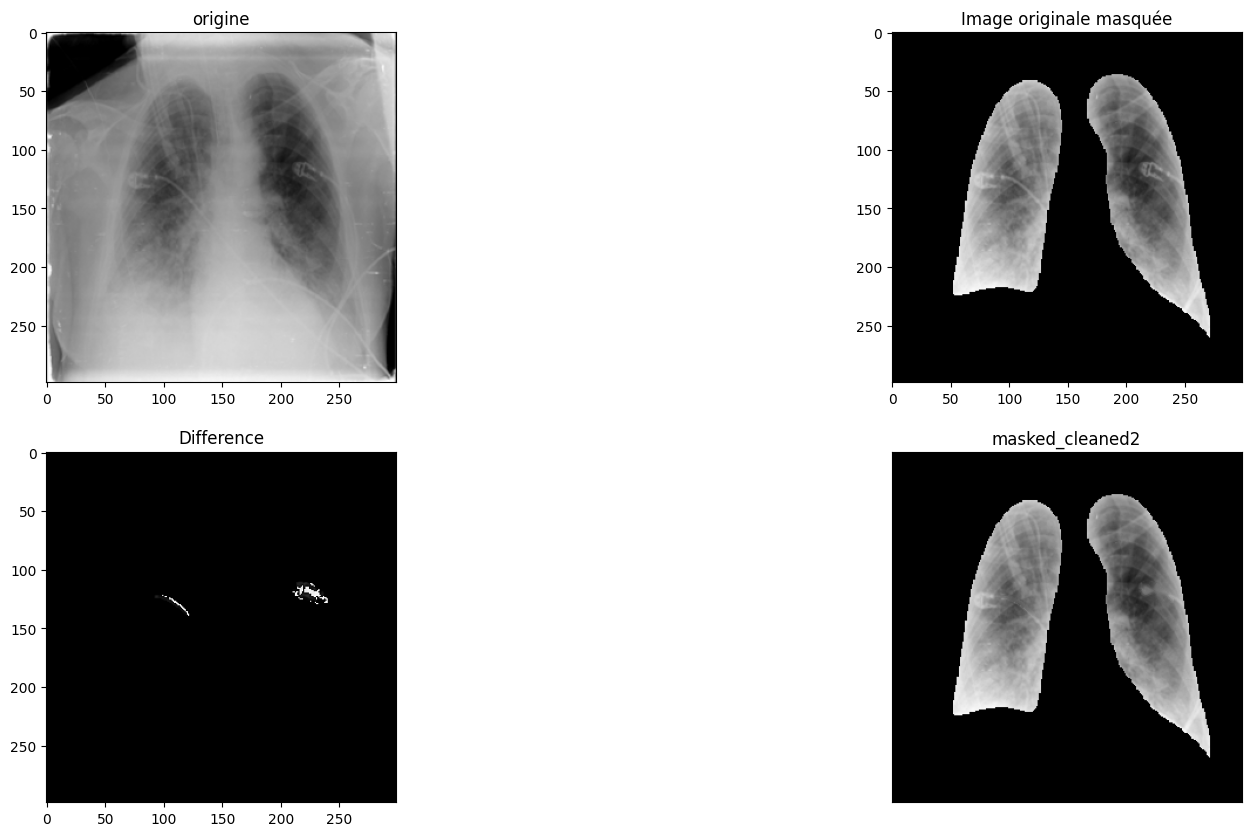

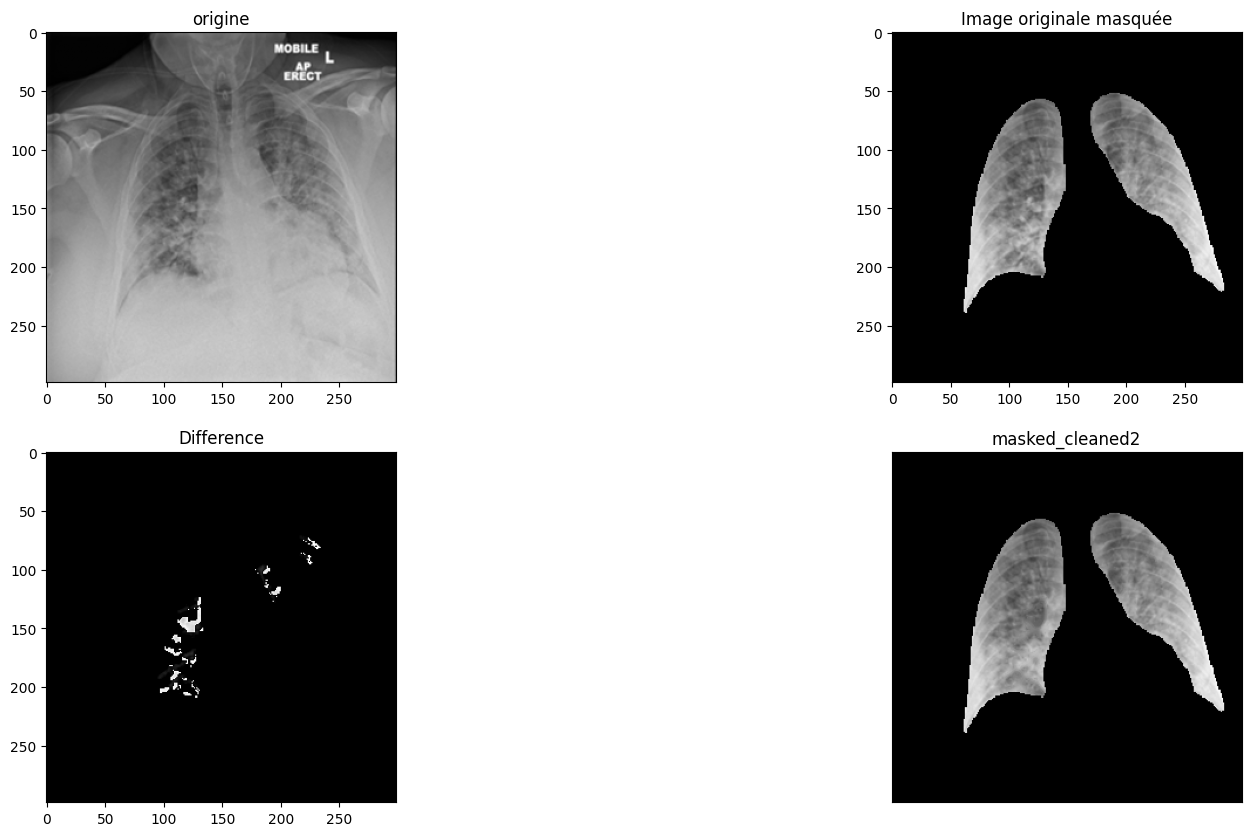

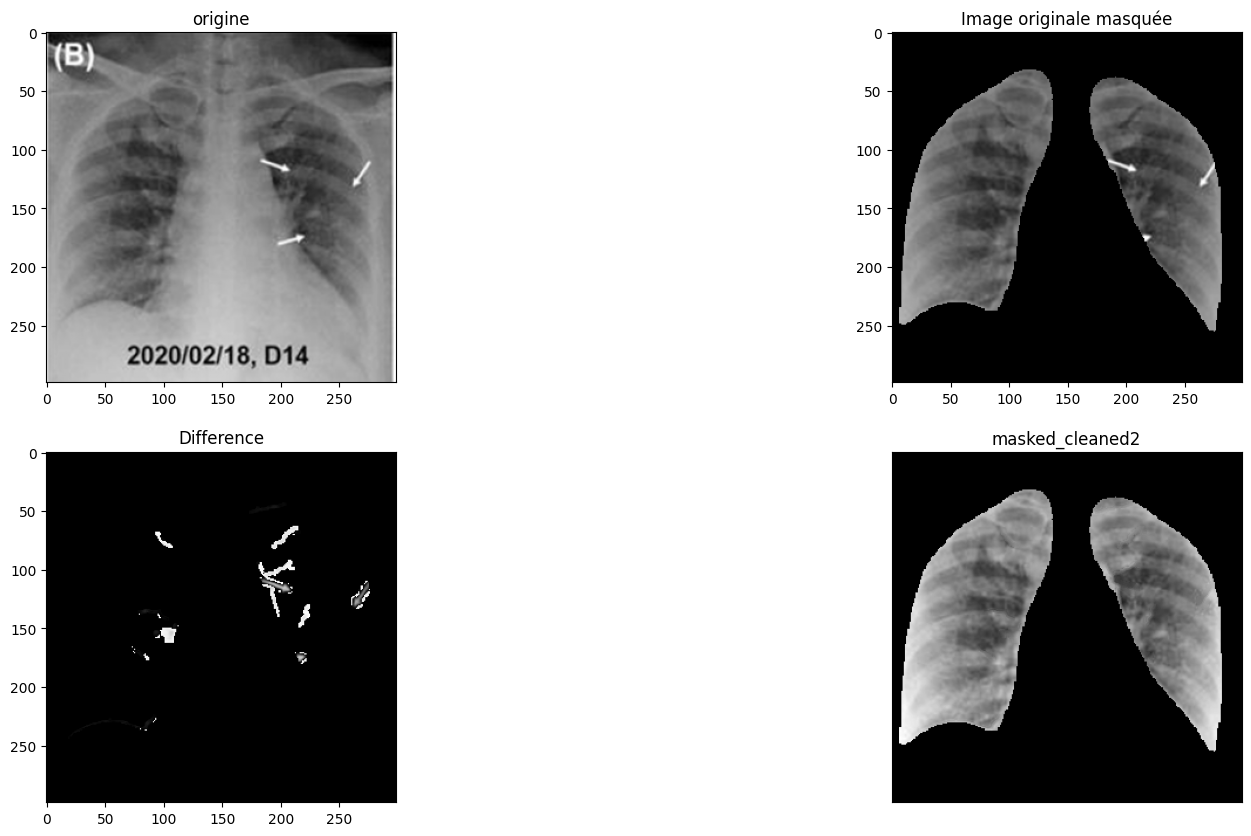

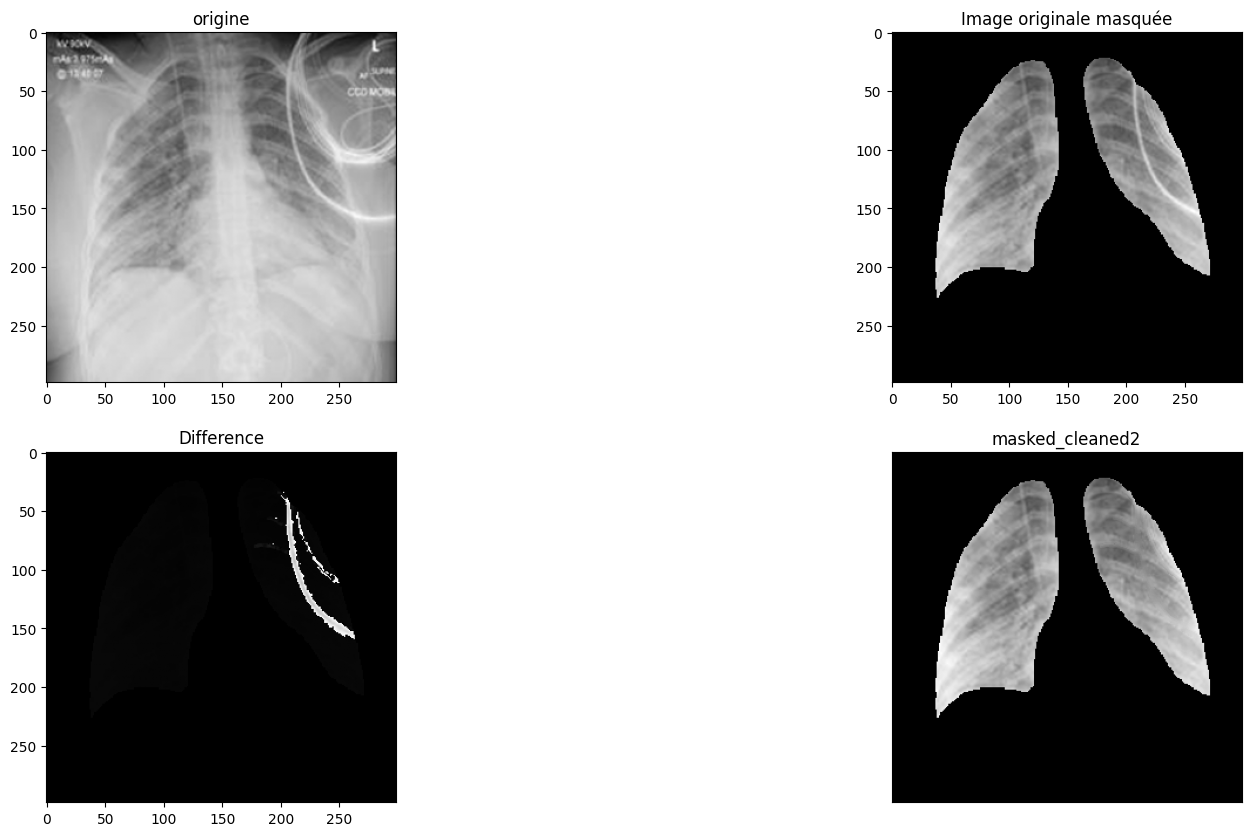

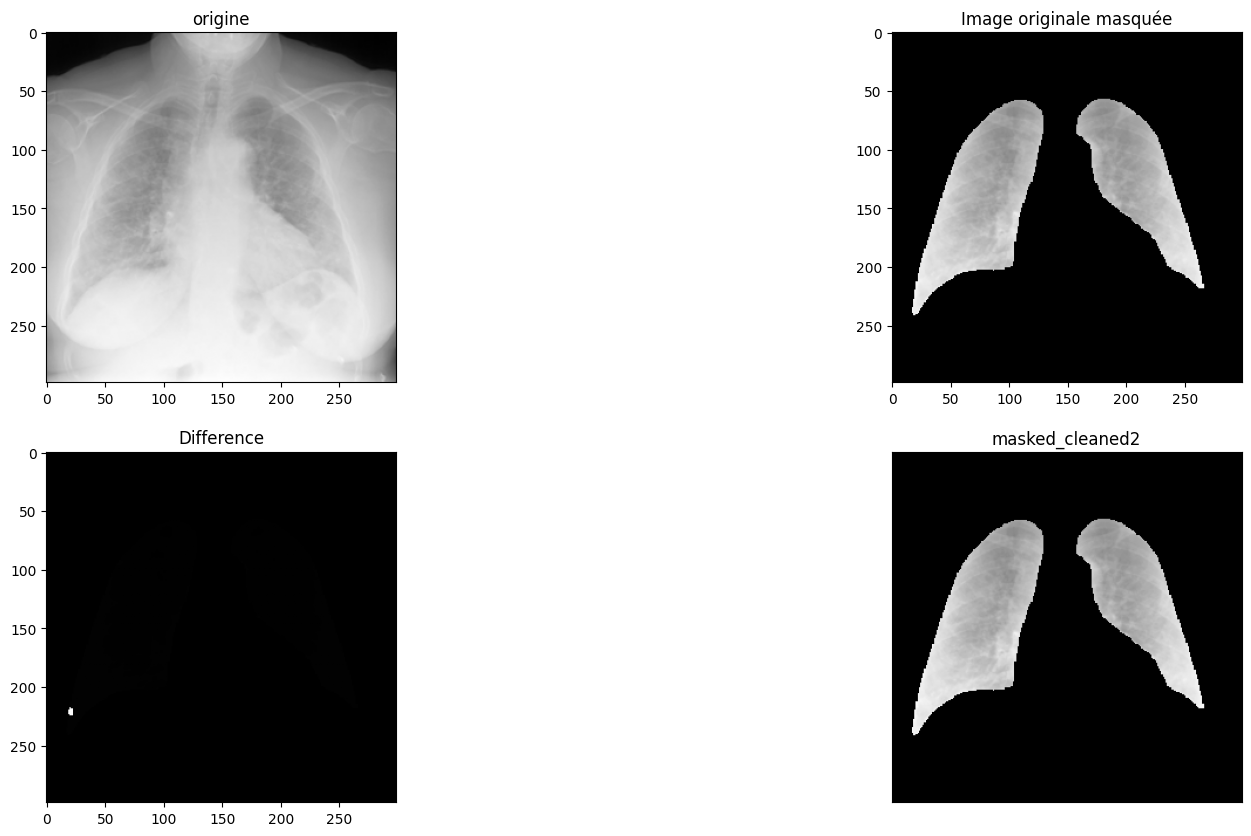

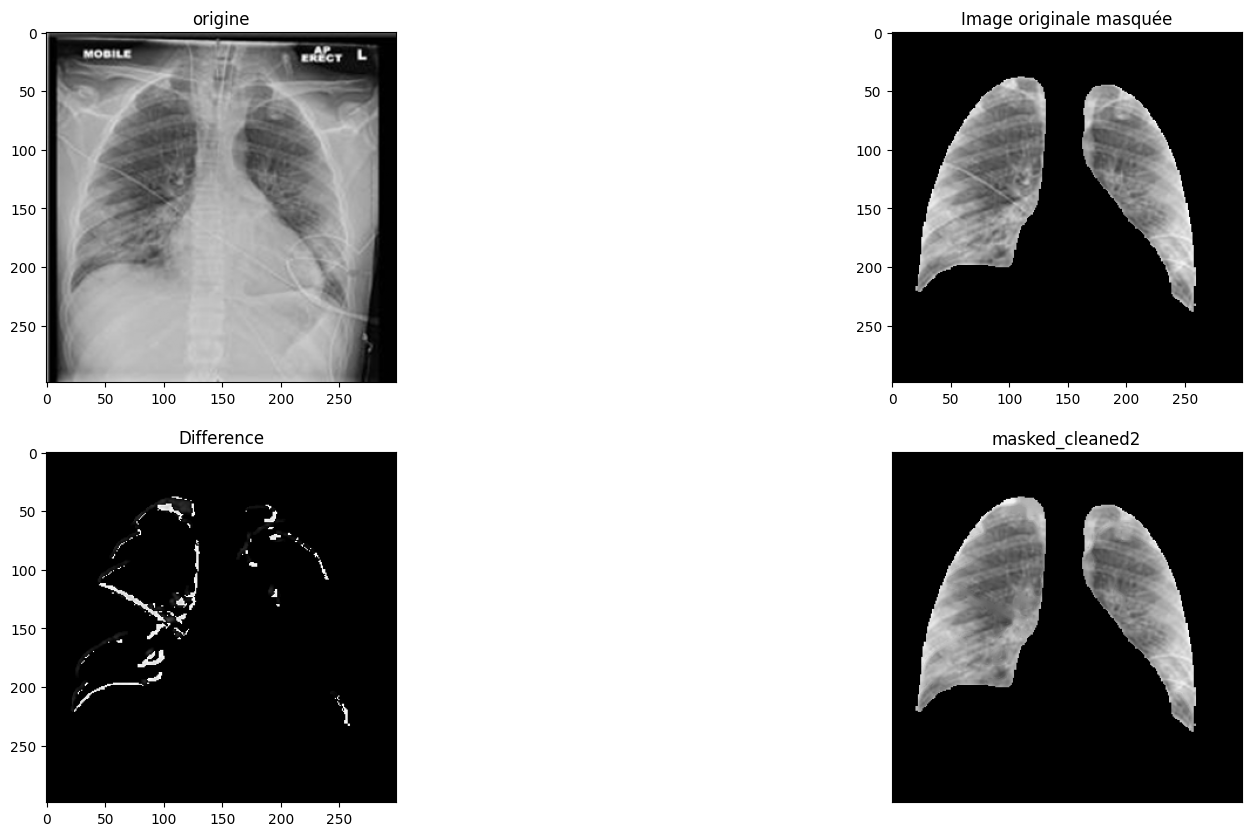

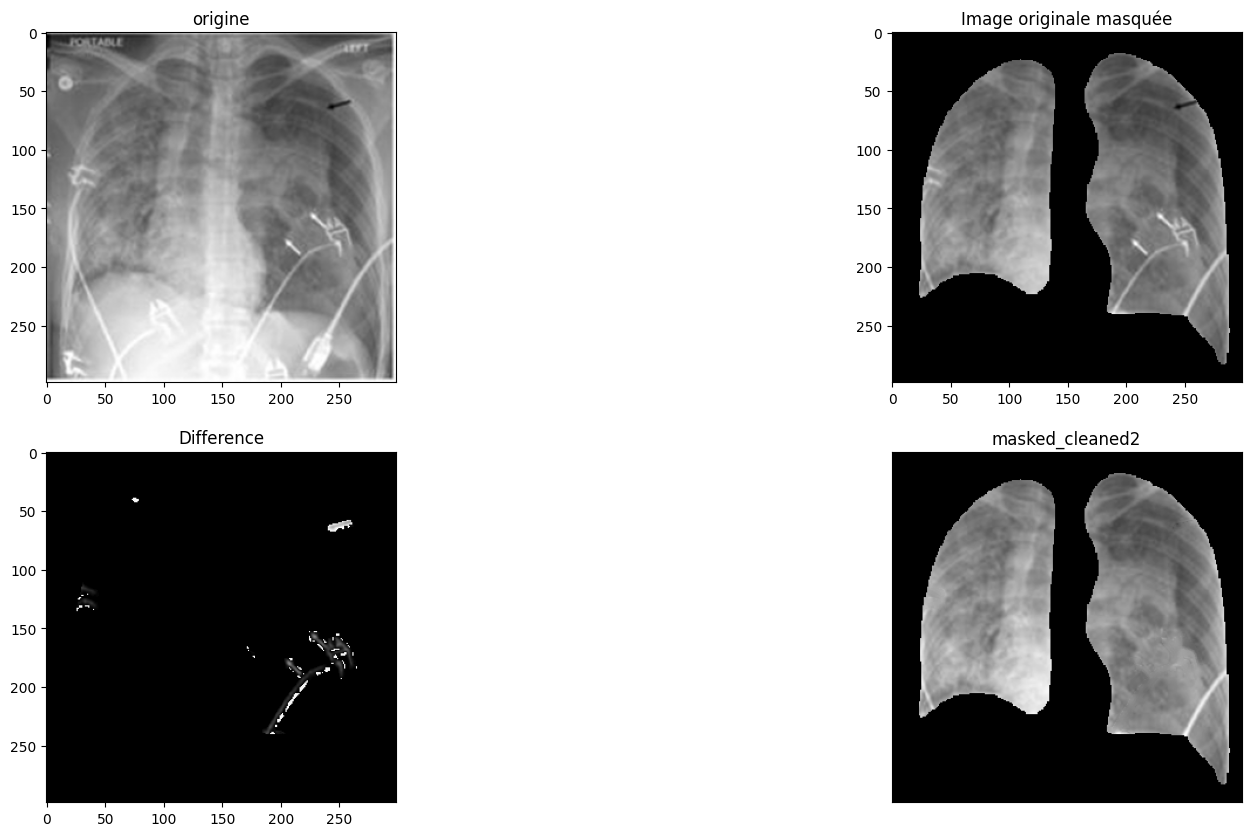

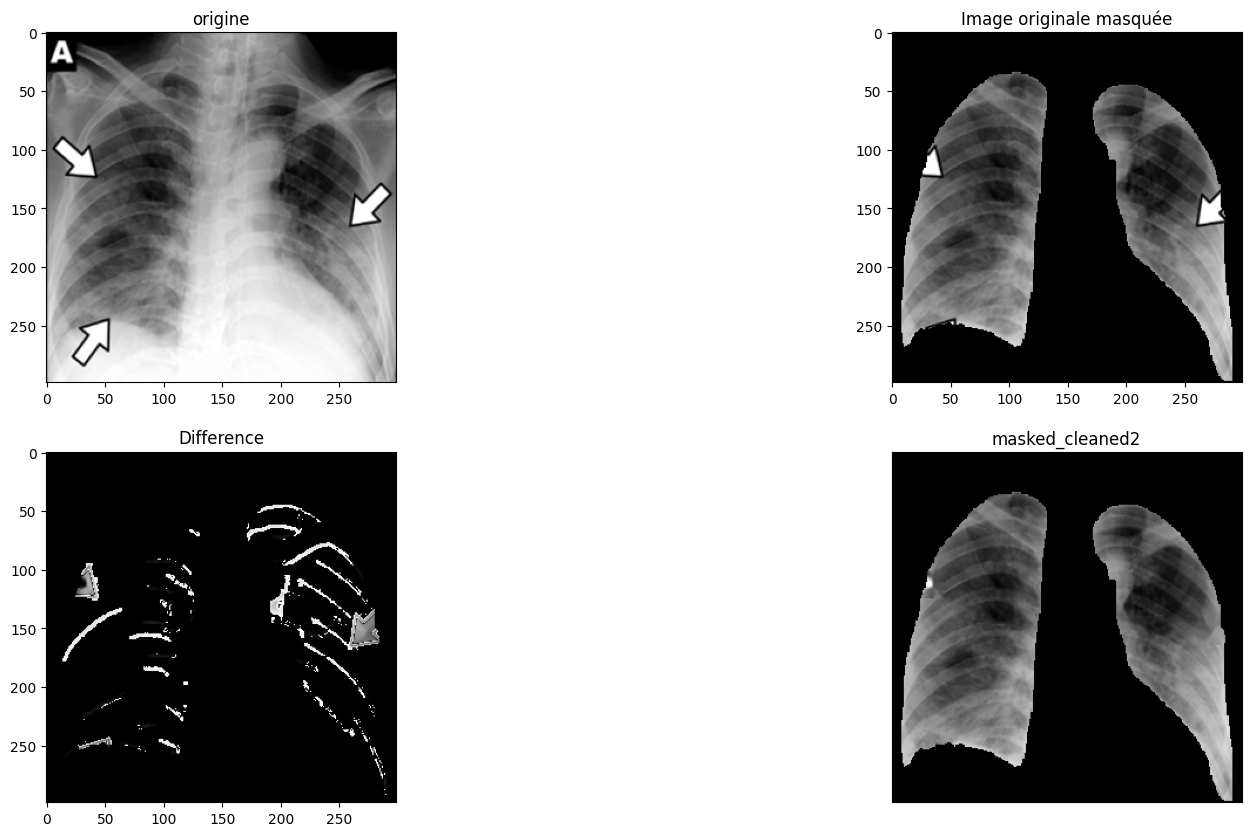

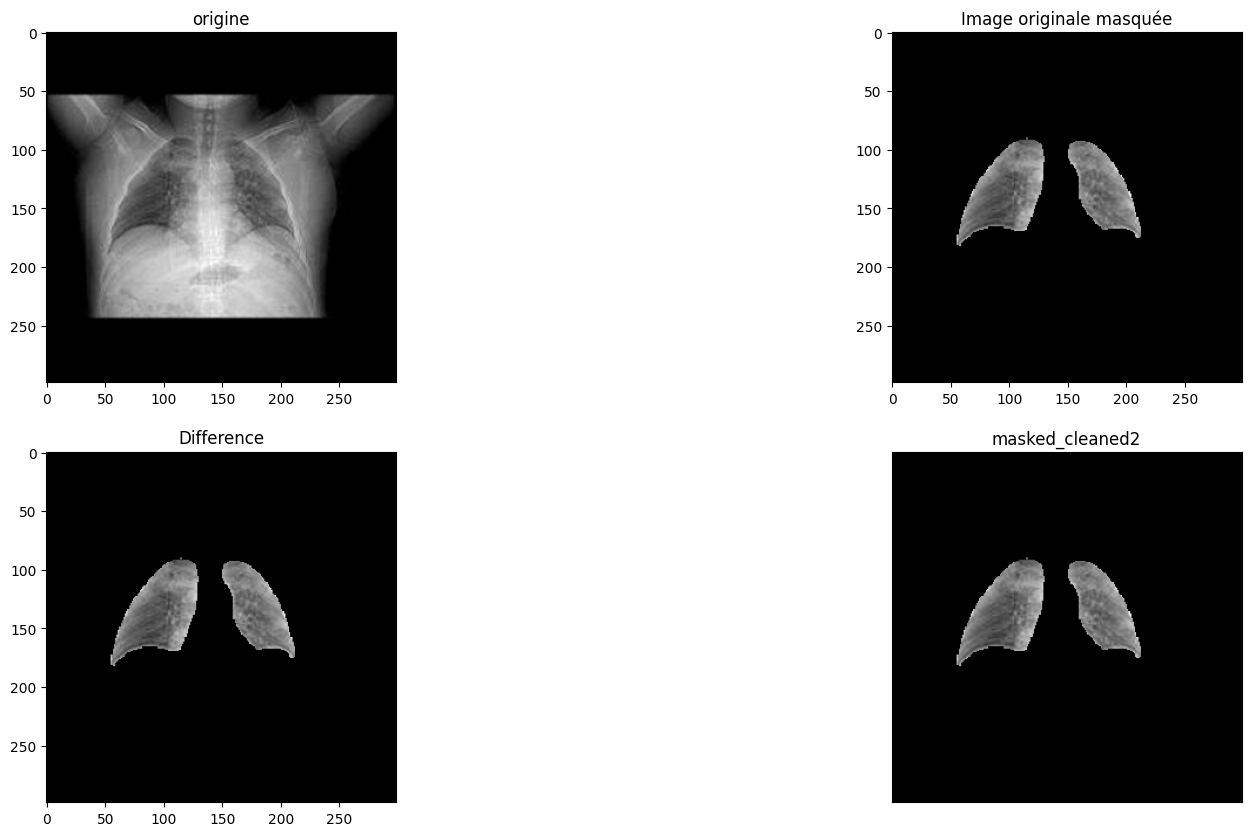

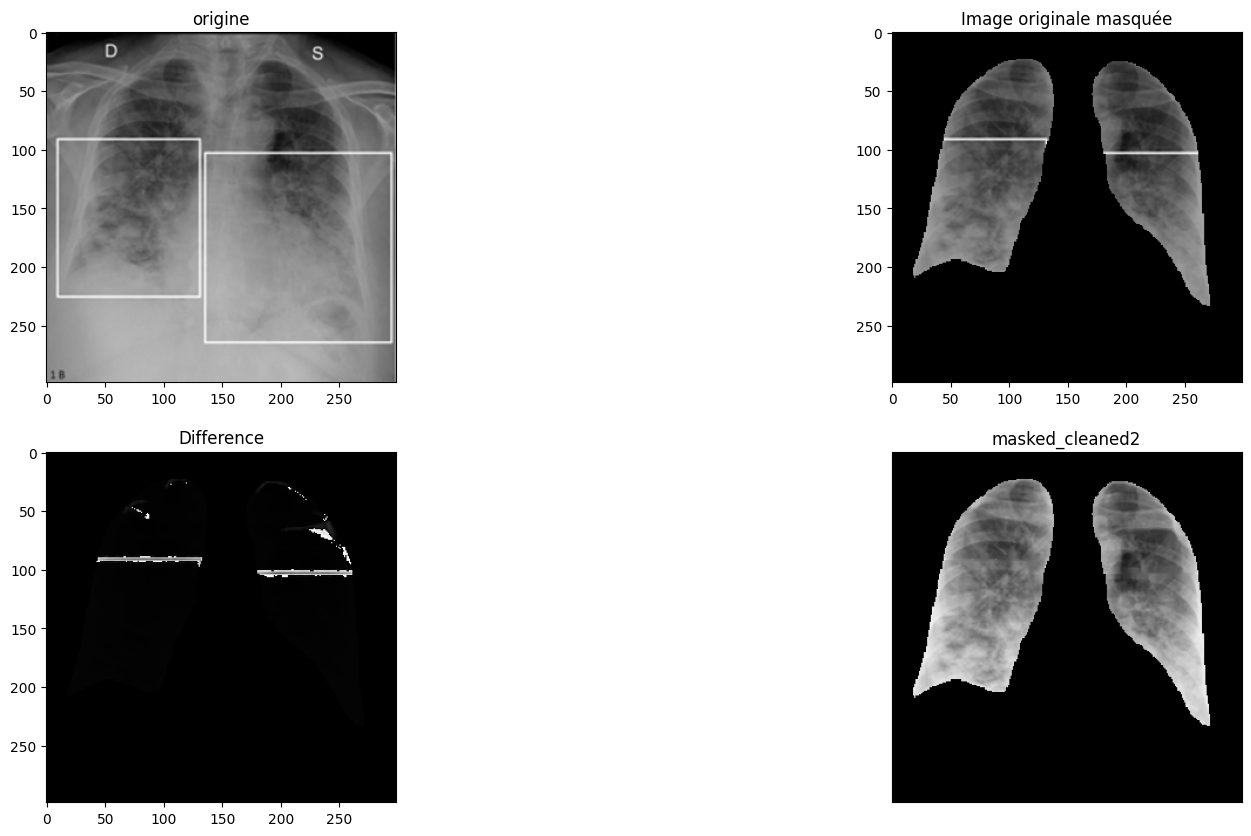

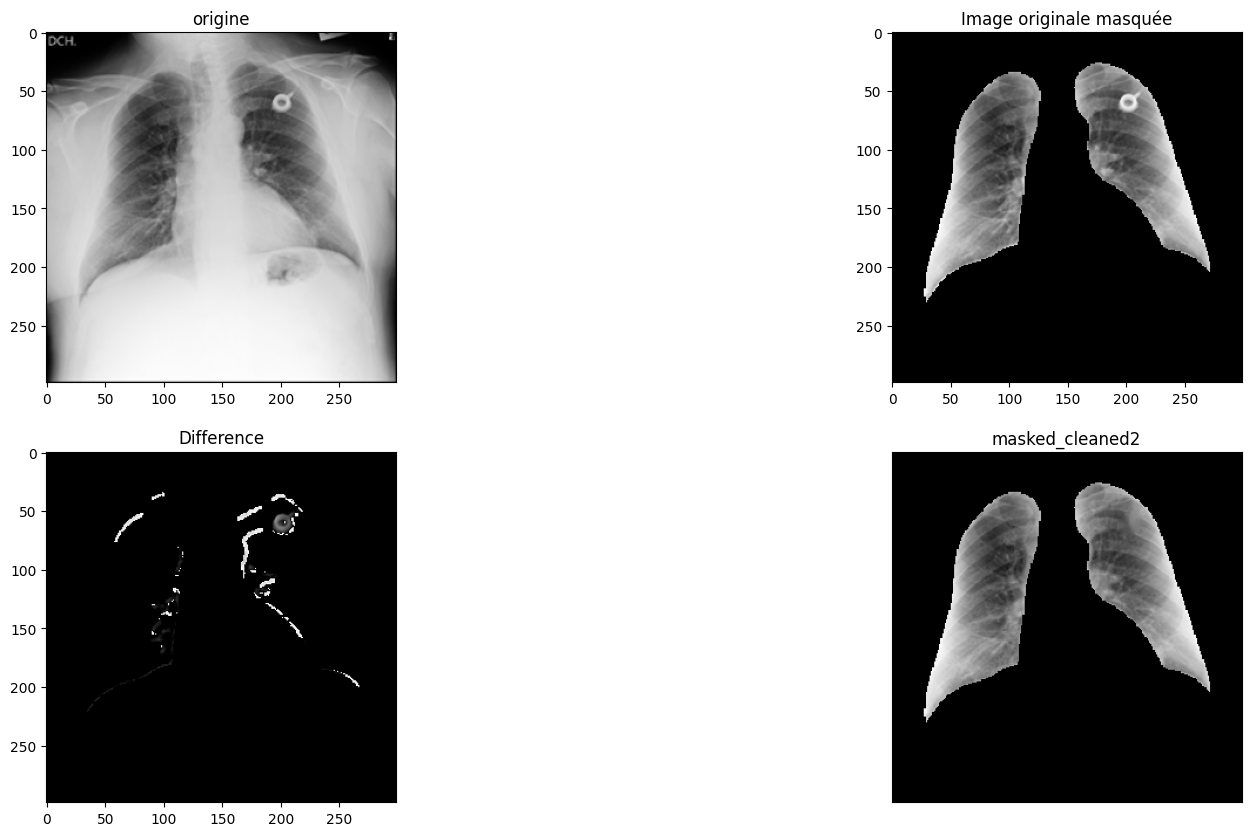

fin


In [48]:


liste_test = ["COVID-3.png", "COVID-161.png", "COVID-168.png", "COVID-183.png", "COVID-193.png", "COVID-213.png", 
              "COVID-318.png", "COVID-450.png", "COVID-481.png", "COVID-1837.png", "COVID-2560.png"]

debug_mode = False
controle_mode = True

# Paths
PROJECT_ROOT = Path(os.getcwd())  # racine du projet
DATASET_ROOT = PROJECT_ROOT.parent / "data" # racine du dataset
DATASET_REP  = DATASET_ROOT / "COVID-19_Radiography_Dataset" # Répertoire contenant le dataset
    
for img_name in liste_test:
                   
    img_path = DATASET_REP / "COVID" / "images" / img_name
    mask_path = DATASET_REP / "COVID" / "masks" / img_name
        
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    resized_mask = cv2.resize(mask, img.shape, interpolation=cv2.NEIGH_FLANN_KNN)
        
    masked_img = cv2.bitwise_and(img, resized_mask)
            
    cleaned = artefact_preprocessing(img=img, resized_mask=resized_mask, color_map=1, debug_mode=debug_mode)

    masked_cleaned_img = cv2.bitwise_and(cleaned, resized_mask)
        
    loss = image_loss(masked_img, masked_cleaned_img)
        
    if controle_mode:
        plt.figure(figsize = (20,10))

        plt.subplot(2,2,1)
        plt.imshow(img, cmap = 'gray')
        plt.title("origine")
        plt.subplot(2,2,2)
        plt.imshow(masked_img, cmap = 'gray')
        plt.title("Image originale masquée")
        plt.subplot(2,2,3)
        plt.imshow(loss, cmap = 'gray')
        plt.title("Difference")
        plt.subplot(2,2,4)
        plt.imshow(masked_cleaned_img, cmap = 'gray')
        plt.title("masked_cleaned2")

        plt.xticks([])
        plt.yticks([])
        plt.show();
    
print(f"fin")